In [1]:
import pandas as pd
import numpy as np
import holidays
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import datetime

from matplotlib import pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

In [3]:
daily_data = pd.read_csv("../podaci/vremenske-serije/date_day_norm.csv")
daily_data = daily_data.astype({'date': 'datetime64[ns]'})

# 1. koji range imamo:
min_date = daily_data['date'].min()
max_date = daily_data['date'].max()
daily_data.set_index('date', inplace=True)

date_range = pd.date_range(min_date, max_date, freq='D')

# 2. left-join na date_range sa našim datumima
date_range_series = pd.Series(index=date_range, dtype='int64')
daily_data_filled = pd.concat([daily_data,
                               date_range_series[~date_range_series.index.isin(daily_data.index)]]).sort_index()

daily_data_filled = daily_data_filled.drop([0], axis=1).fillna(0).astype({'demand_value': 'float32'})
daily_data_filled['date'] = daily_data_filled.index
daily_data_filled.reset_index(drop=True, inplace=True)

# izbaci nedelje iz podataka i vidi kako izgledaju stvari bez njih -> -> ->
no_sundays_data = daily_data_filled[daily_data_filled['date'].apply(lambda x: pd.to_datetime(x).day_name()) != 'Sunday'].reset_index(drop=True)

In [4]:
no_sundays_data

,demand_value,date
0,0.098039,2019-12-18
1,0.245098,2019-12-19
2,0.401961,2019-12-20
3,0.000000,2019-12-21
4,0.490196,2019-12-23
...,...,...
449,1.078431,2021-05-25
450,1.245098,2021-05-26
451,1.284314,2021-05-27
452,1.000000,2021-05-28


In [5]:
n_past_days = 30

xgb_data = pd.concat([
    no_sundays_data['date'], 
    no_sundays_data['demand_value']], 
    axis=1)

xgb_data = xgb_data.rename(columns={"demand_value": "target_1"})

# Dodaj poslednjih n_past_days dana kao atribute
for n in range(1, n_past_days+1):
    xgb_data = pd.concat([
        xgb_data, 
        no_sundays_data['demand_value'].rename(f"day_{n}").shift(n)
    ], axis=1)
    
n_future_days = 29

# Dodaj target vrednosti za dane
for n in range(2, n_future_days):
    xgb_data = pd.concat([
        xgb_data,
        no_sundays_data['demand_value'].rename(f"target_{n}").shift(-n+1)
    ], axis=1)
    

In [6]:
xgb_data.head()

,date,target_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28
0,2019-12-18,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245098,0.401961,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412
1,2019-12-19,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401961,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333
2,2019-12-20,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765
3,2019-12-21,0.000000,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765,0.735294
4,2019-12-23,0.490196,0.000000,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765,0.735294,0.872549


In [7]:
sweden_holidays = holidays.Sweden(years=[2018, 2019, 2020, 2021])
sweden_dates = []

for date in sweden_holidays.items():
    if date[1] != "Söndag":
        sweden_dates.append(date[0])
        
sweden_dates_not_sunday = [sweden_date for sweden_date in sweden_dates if (sweden_date.weekday() not in [7])]
len(sweden_dates_not_sunday)

64

In [8]:
holidays_df = pd.DataFrame(
    sweden_dates_not_sunday, columns=["date"]
).value_counts().reset_index().rename(columns={0:"number_of_holidays"})
holidays_df = holidays_df.astype({"date": 'datetime64[ns]'})

In [9]:
holidays_df.dtypes

date                  datetime64[ns]
number_of_holidays             int64
dtype: object

In [10]:
xgb_data = xgb_data.merge(holidays_df, 
                          on=["date"], 
                          how="left")

xgb_data["number_of_holidays_next_day"] = xgb_data["number_of_holidays"].shift(-1)
xgb_data["number_of_holidays_previous_day"] = xgb_data["number_of_holidays"].shift(1)

xgb_data["number_of_holidays"] = xgb_data["number_of_holidays"].fillna(0) 
xgb_data["number_of_holidays_next_day"] = xgb_data["number_of_holidays_next_day"].fillna(0) 
xgb_data["number_of_holidays_previous_day"] = xgb_data["number_of_holidays_previous_day"].fillna(0) 

In [11]:
n_covariates = n_past_days
covariates = []

for cov in range(1, n_covariates+1):
    covariates.append(f"day_{cov}")

covariates.append("number_of_holidays")
covariates.append("number_of_holidays_next_day") 
covariates.append("number_of_holidays_previous_day")

def run_xgboost(xgb_train_pd, 
                xgb_test_pd, 
                model_info, 
                look_ahead=1):
    
    n_predictions = look_ahead
    predictions = {}
    
    for pred in range(1, n_predictions+1):
        predictions[f"target_{pred}"] = {}
            
    for instance in range(len(xgb_test_pd)):
        
        training_and_validation_pd = pd.concat([xgb_train_pd, 
                                                xgb_test_pd.iloc[:instance]])
        
        X_train, X_validation, y_train, y_validation = train_test_split(
          training_and_validation_pd[covariates],
          training_and_validation_pd[list(predictions.keys())],
          test_size=0.2,
          random_state=42
        )  
        
        for i in range(look_ahead):

            if i+instance < len(xgb_test_pd):
                
                prediction_date = xgb_test_pd.iloc[instance+i].date
                
                future_to_predict = y_validation
                model = xgb.XGBRegressor(**{"objective": "reg:squarederror", "seed": 42})
                model = model.fit(
                          X_train,
                          y_train[[f"target_{i+1}"]],
                          eval_metric=["rmse"],
                          eval_set=[(X_train, 
                                     y_train[[f"target_{i+1}"]]), 
                                    (X_validation, 
                                     y_validation[[f"target_{i+1}"]])],
                          early_stopping_rounds=30,
                          verbose=False
                        )
                
#                 print("Eval: ", model.evals_result)
                output = model.predict(xgb_test_pd.iloc[[instance]][covariates])
                future_to_predict = xgb_test_pd.iloc[instance+i]['date'] #+ datetime.timedelta(days=i)
                predictions[f"target_{i+1}"][future_to_predict] = output[0]
                
    return predictions, model

In [12]:
xgb_data.head()

,date,target_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,number_of_holidays,number_of_holidays_next_day,number_of_holidays_previous_day
0,2019-12-18,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245098,0.401961,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,0.0,0.0,0.0
1,2019-12-19,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401961,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.0,0.0,0.0
2,2019-12-20,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765,0.0,0.0,0.0
3,2019-12-21,0.000000,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490196,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765,0.735294,0.0,0.0,0.0
4,2019-12-23,0.490196,0.000000,0.401961,0.245098,0.098039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.519608,0.019608,0.500000,0.000000,0.000000,0.539216,0.186275,0.000000,0.000000,0.598039,0.382353,0.382353,0.343137,0.019608,0.941176,0.705882,0.549020,0.823529,1.049020,0.029412,1.333333,0.911765,0.735294,0.872549,0.0,1.0,0.0


In [13]:
date_to_start = "2021-03-01"
look_ahead = 28 #dana
date_col = "date"

train_pd = xgb_data[xgb_data[date_col] < date_to_start]
test_pd =  xgb_data[xgb_data[date_col] >= date_to_start]

In [14]:
%%time

xgboost_result = run_xgboost(train_pd.dropna(), 
                             test_pd,
                             model_info="nothing", 
                             look_ahead=look_ahead)

CPU times: user 11min 47s, sys: 9.63 s, total: 11min 56s
Wall time: 3min 22s


In [ ]:
tmp_df = pd.DataFrame(data=[val for key,val  in xgboost_result[0].items()]).T
column_names = tmp_df.columns
xgboost_final_df = tmp_df.rename(columns=lambda x: 'target_' + str(x+1) if x in column_names else x)

In [ ]:
# xgb_data[xgb_data['date'] >='2021-04-01'][['date', 'target_1']]

In [ ]:
# xgboost_final_df

In [ ]:
# 2021-04-01
final_df_2021_04_01 = xgboost_final_df.dropna(axis=0, how='any')
final_df_2021_04_01['date'] = final_df_2021_04_01.index

In [ ]:
actual = xgb_data[xgb_data['date'] >='2021-04-01'][['date', 'target_1']]
len(actual), len(final_df_2021_04_01)

In [ ]:
final_df_2021_04_01.insert(0, "actual", list(actual['target_1']))

In [ ]:
final_df_2021_04_01

In [ ]:
# columns = ["target_1", "target_2", "target_3"]# "target_4", "target_5", "target_6"]

# fig, ax = plt.subplots(3, 1, figsize=(20, 8))
# ax = ax.flatten()

# for i, col in enumerate(columns):
#     ax[i].plot(final_df_2021_04_01["actual"] - final_df_2021_04_01[col], 'x', c='r')
    
#     ax[i].hlines(0, 
#                  xmin=final_df_2021_04_01.index.min(), 
#                  xmax=final_df_2021_04_01.index.max(), 
#                  linestyles='dashed')
    
#     ax[i].set_title(col)
#     ax[i].set_xlim([final_df_2021_04_01.index.min(), final_df_2021_04_01.index.max()])
#     ax[i].set_ylim([-100, 100])
# fig.autofmt_xdate()
# plt.tight_layout()
# plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

plt.scatter(final_df_2021_04_01['date'], final_df_2021_04_01['actual'], label='actual')
plt.scatter(final_df_2021_04_01['date'], final_df_2021_04_01['target_1'], label='model_1')
# plt.scatter(final_df_2021_04_01['date'], final_df_2021_04_01['target_2'], label='mdoel_2')
plt.legend()
plt.show()

In [ ]:
columns = final_df_2021_04_01.columns
metrics = []

for column in columns:
    df = final_df_2021_04_01[['date', column]]
        
    dict_metrics = {}
    dict_metrics['model'] = column

    if (list(actual['date']) == list(df['date'])):
        mse, rmse, mae, r2 = regression_insights(actual['target_1'], df[column])
        dict_metrics['mse'] = mse
        dict_metrics['rmse'] = rmse
        dict_metrics['mae'] = mae
        dict_metrics['r2'] = r2

        smape_value = smape(actual['target_1'], df[column])
        dict_metrics['smape'] = smape_value

        bias_value = bias(actual['target_1'], df[column])
        dict_metrics['bias'] = bias_value
        metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

In [ ]:
metrics_df

In [ ]:
xgboost_result[1].feature_importances_

In [ ]:
cols = final_df_2021_04_01.columns
cols = cols.delete(-1)

# negativne vrednosti postavi na 0
for col in cols:
    final_df_2021_04_01[col] = final_df_2021_04_01[col].apply(lambda x : x if x > 0 else 0)

metrics = []

for column in columns:
    df = final_df_2021_04_01[['date', column]]
        
    dict_metrics = {}
    dict_metrics['model'] = column

    if (list(actual['date']) == list(df['date'])):
        mse, rmse, mae, r2 = regression_insights(actual['target_1'], df[column])
        dict_metrics['mse'] = mse
        dict_metrics['rmse'] = rmse
        dict_metrics['mae'] = mae
        dict_metrics['r2'] = r2

        smape_value = smape(actual['target_1'], df[column])
        dict_metrics['smape'] = smape_value

        bias_value = bias(actual['target_1'], df[column])
        dict_metrics['bias'] = bias_value
        metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

metrics_df # 0.911814	0.117928 pre round

### Dodajem srednju vrednost za prethodnih 6 dana kao 1 atribut

In [ ]:
xgb_data_average = xgb_data.copy()

In [ ]:
if 'average_6' in xgb_data_average.columns:
    xgb_data_average.drop(columns=['average_6'], axis=1, inplace=True)
    
xgb_data_average.insert(1, "average_6", xgb_data_average['target_1'].shift().rolling(window=6).mean())

In [ ]:
xgb_data_average.head(10)

In [ ]:
covariates.append("average_6")

date_to_start = "2021-03-01"
look_ahead = 28 #dana
date_col = "date"

train_pd = xgb_data_average[xgb_data_average[date_col] < date_to_start]
test_pd =  xgb_data_average[xgb_data_average[date_col] >= date_to_start]

In [ ]:
%%time

xgboost_result = run_xgboost(train_pd.dropna(), 
                             test_pd,
                             model_info="nothing", 
                             look_ahead=look_ahead)

In [ ]:
tmp_df = pd.DataFrame(data=[val for key,val  in xgboost_result[0].items()]).T
column_names = tmp_df.columns
xgboost_final_df = tmp_df.rename(columns=lambda x: 'target_' + str(x+1) if x in column_names else x)

# 2021-04-01
final_df_2021_04_01 = xgboost_final_df.dropna(axis=0, how='any')
final_df_2021_04_01['date'] = final_df_2021_04_01.index

actual = xgb_data[xgb_data['date'] >='2021-04-01'][['date', 'target_1']]
print(len(actual), len(final_df_2021_04_01))

final_df_2021_04_01.insert(0, "actual", list(actual['target_1']))

columns = final_df_2021_04_01.columns
metrics = []

for column in columns:
    df = final_df_2021_04_01[['date', column]]
        
    dict_metrics = {}
    dict_metrics['model'] = column

    if (list(actual['date']) == list(df['date'])):
        mse, rmse, mae, r2 = regression_insights(actual['target_1'], df[column])
        dict_metrics['mse'] = mse
        dict_metrics['rmse'] = rmse
        dict_metrics['mae'] = mae
        dict_metrics['r2'] = r2

        smape_value = smape(actual['target_1'], df[column])
        dict_metrics['smape'] = smape_value

        bias_value = bias(actual['target_1'], df[column])
        dict_metrics['bias'] = bias_value
        metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

### Dodajem prosek razlike od srednje vrednosti za prethodnih 6 dana kao 1 atribut

In [ ]:
xgb_data_average_error = xgb_data_average.copy()
xgb_data_average_error.insert(0, 
                              "average_error_6", 
                              xgb_data_average_error['target_1'].shift().rolling(window=6).apply(
                                  func=(lambda x: np.mean(np.abs(x - x.mean()))), 
                                  raw=True)
                             )
xgb_data_average_error.head(10)

In [ ]:
covariates.append("average_error_6")

date_to_start = "2021-03-01"
look_ahead = 28 #dana
date_col = "date"

train_pd = xgb_data_average_error[xgb_data_average_error[date_col] < date_to_start]
test_pd =  xgb_data_average_error[xgb_data_average_error[date_col] >= date_to_start]

In [ ]:
%%time

xgboost_result = run_xgboost(train_pd.dropna(), 
                             test_pd,
                             model_info="nothing", 
                             look_ahead=look_ahead)

In [ ]:
tmp_df = pd.DataFrame(data=[val for key,val  in xgboost_result[0].items()]).T
column_names = tmp_df.columns
xgboost_final_df = tmp_df.rename(columns=lambda x: 'target_' + str(x+1) if x in column_names else x)

# 2021-04-01
final_df_2021_04_01 = xgboost_final_df.dropna(axis=0, how='any')
final_df_2021_04_01['date'] = final_df_2021_04_01.index

actual = xgb_data[xgb_data['date'] >='2021-04-01'][['date', 'target_1']]
print(len(actual), len(final_df_2021_04_01))

final_df_2021_04_01.insert(0, "actual", list(actual['target_1']))

columns = final_df_2021_04_01.columns
metrics = []

for column in columns:
    df = final_df_2021_04_01[['date', column]]
        
    dict_metrics = {}
    dict_metrics['model'] = column

    if (list(actual['date']) == list(df['date'])):
        mse, rmse, mae, r2 = regression_insights(actual['target_1'], df[column])
        dict_metrics['mse'] = mse
        dict_metrics['rmse'] = rmse
        dict_metrics['mae'] = mae
        dict_metrics['r2'] = r2

        smape_value = smape(actual['target_1'], df[column])
        dict_metrics['smape'] = smape_value

        bias_value = bias(actual['target_1'], df[column])
        dict_metrics['bias'] = bias_value
        metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

In [15]:
xgboost_result[1]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
explainer = shap.Explainer(xgboost_result[1])
shap_values = explainer(train_pd[covariates])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


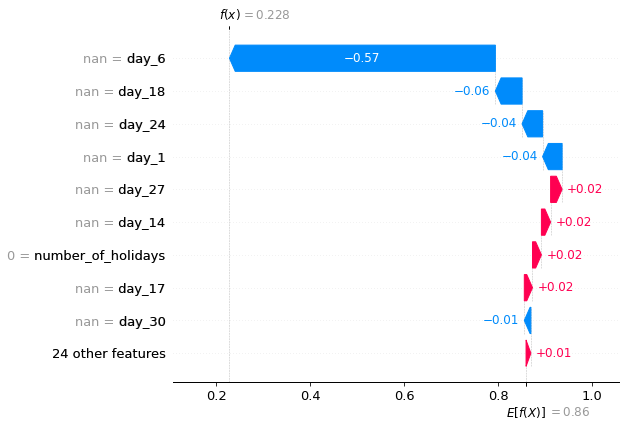

In [17]:
shap.plots.waterfall(shap_values[0])

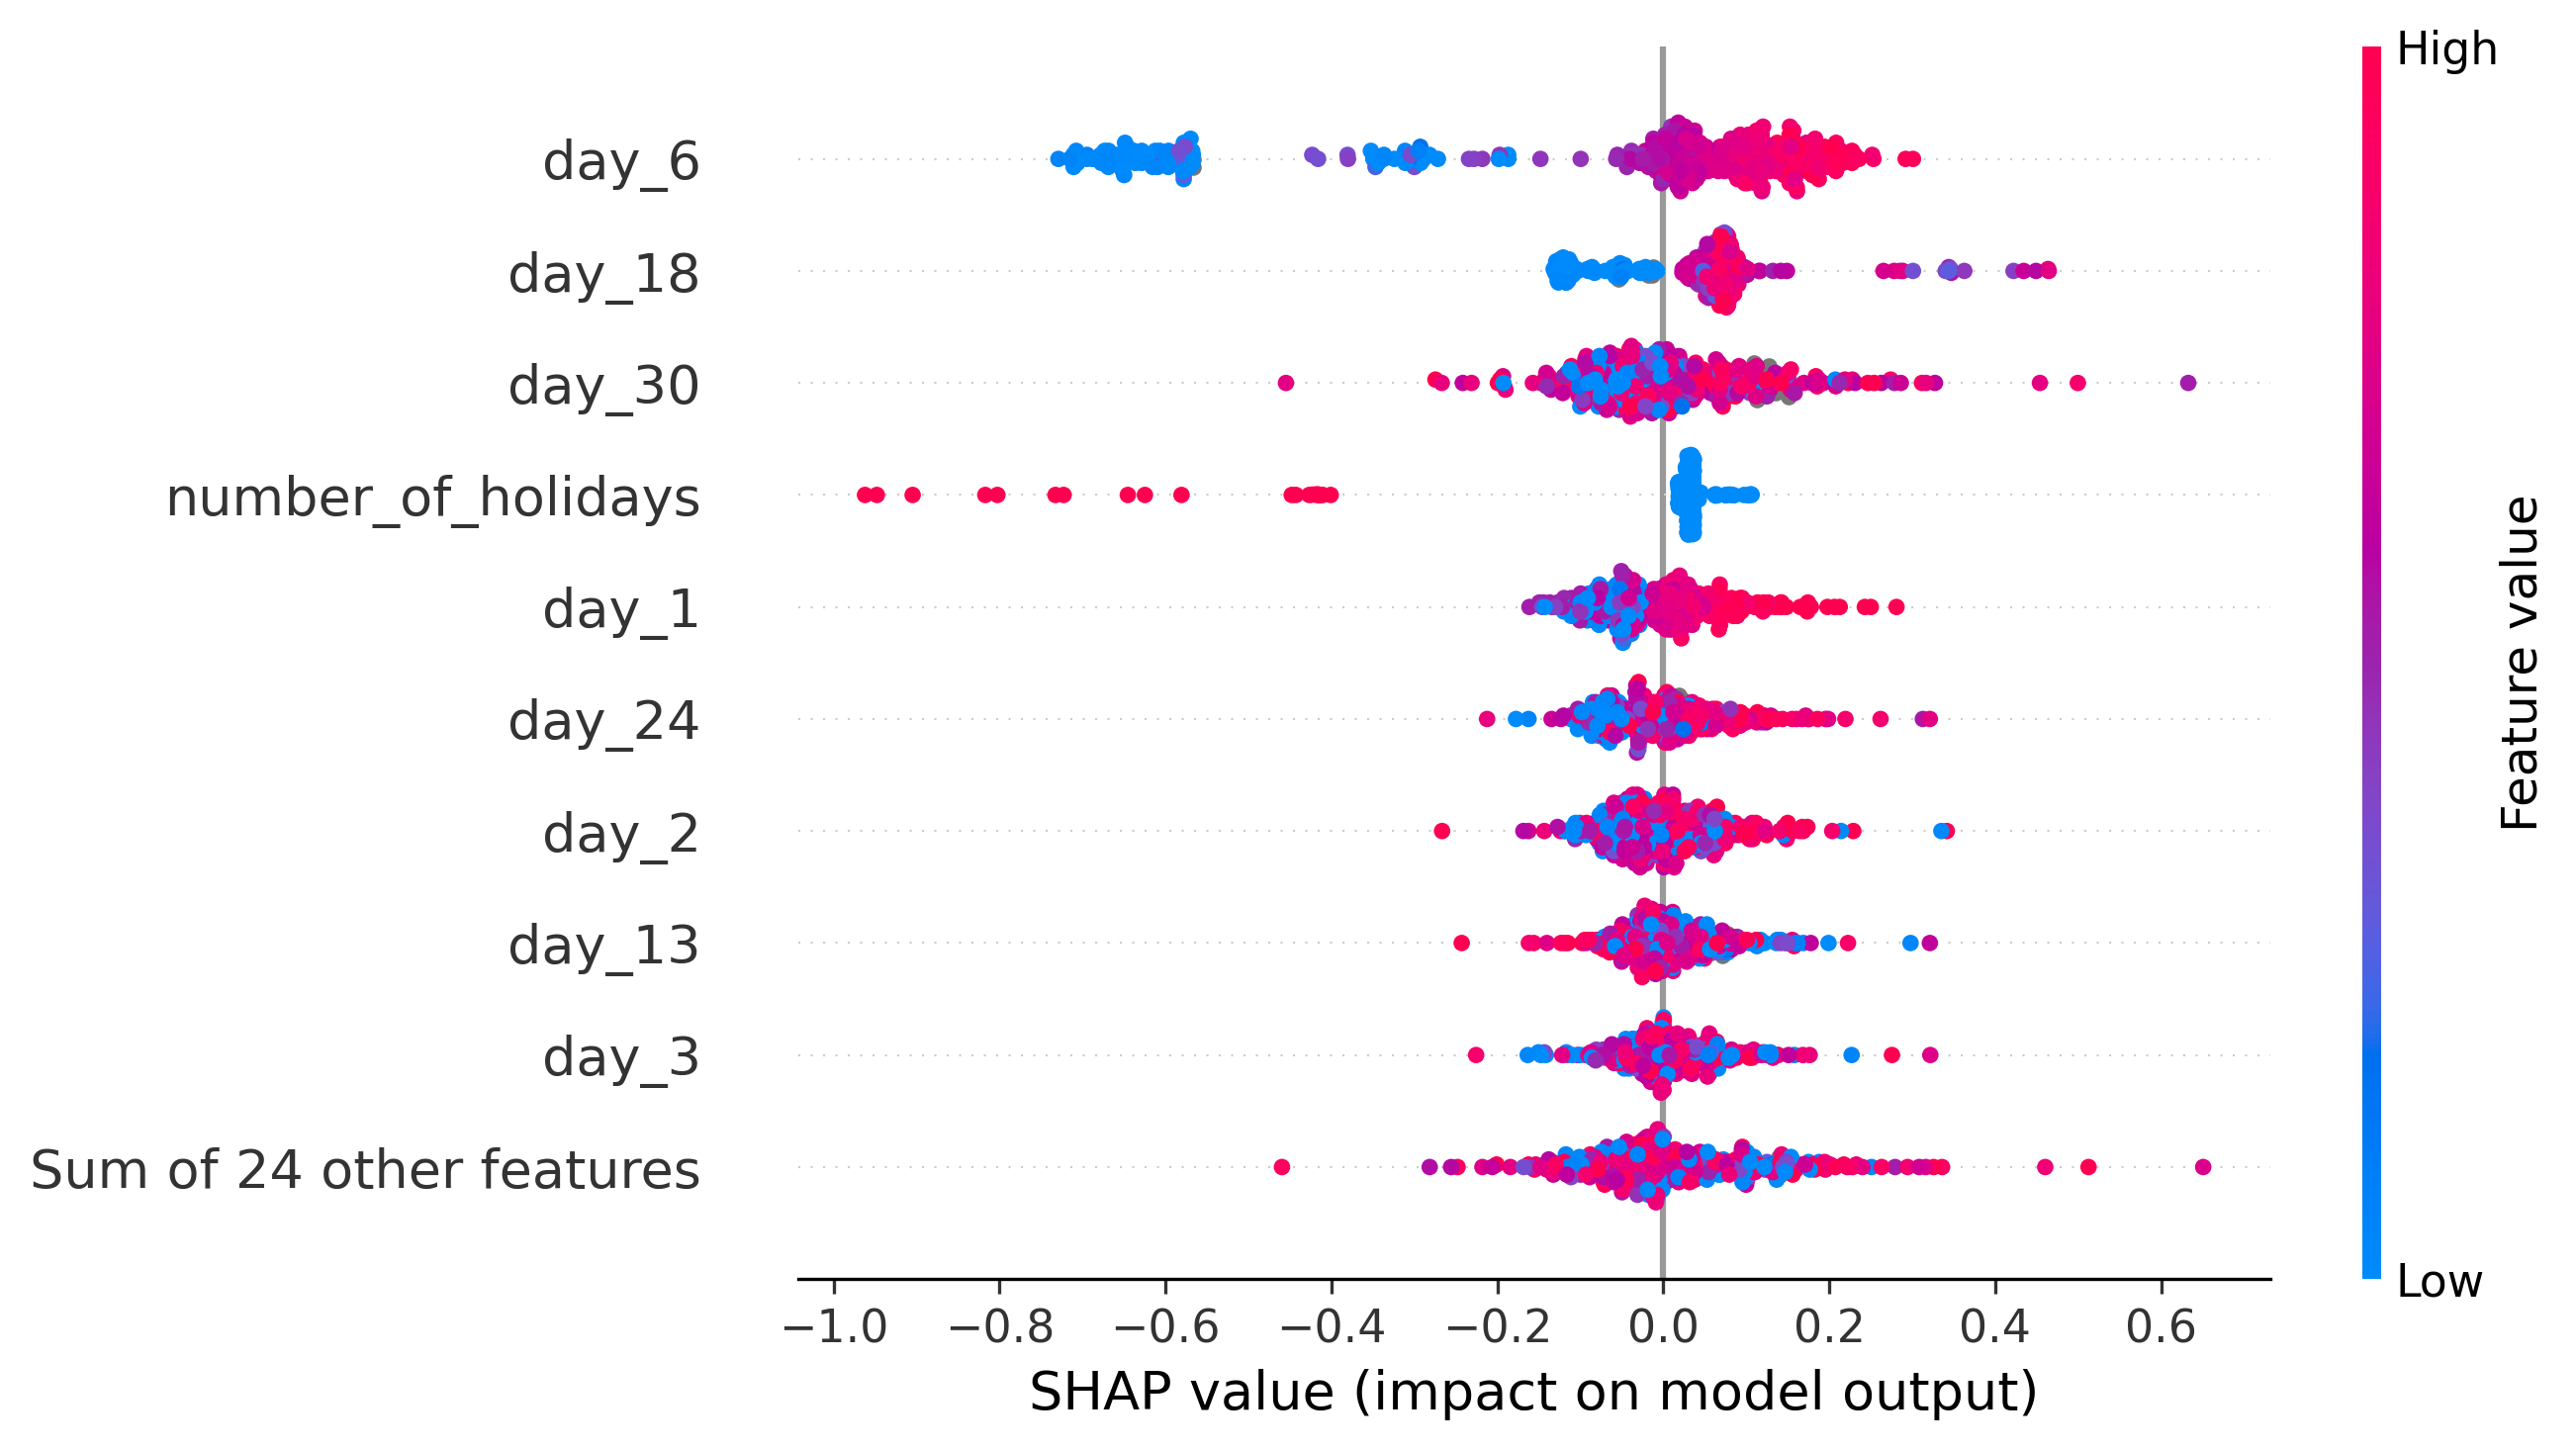

In [29]:
plt.figure(figsize=(18, 9), dpi=300)
fig = shap.plots.beeswarm(shap_values, show=False)
# plt.savefig("../../grafici/shap_xgboost_dnevni.png", dpi=300)

In [19]:
xgboost_result[1].feature_importances_

array([0.00794075, 0.00629401, 0.00511439, 0.00234501, 0.00245581,
       0.42707652, 0.0020948 , 0.00207992, 0.00157057, 0.0035512 ,
       0.00304402, 0.00182108, 0.00567753, 0.00143691, 0.00109723,
       0.00155572, 0.0033229 , 0.08218686, 0.00293316, 0.00355283,
       0.00354679, 0.00391645, 0.00104043, 0.01375661, 0.0011694 ,
       0.00137136, 0.00357201, 0.00281513, 0.00125128, 0.00372967,
       0.39017874, 0.0065008 , 0.        ], dtype=float32)

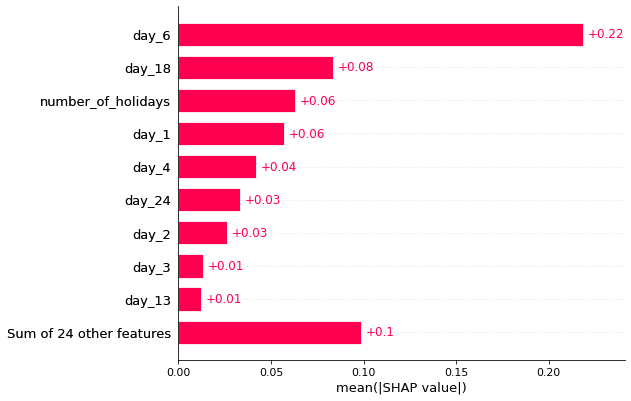

In [20]:
shap.plots.bar(shap_values)

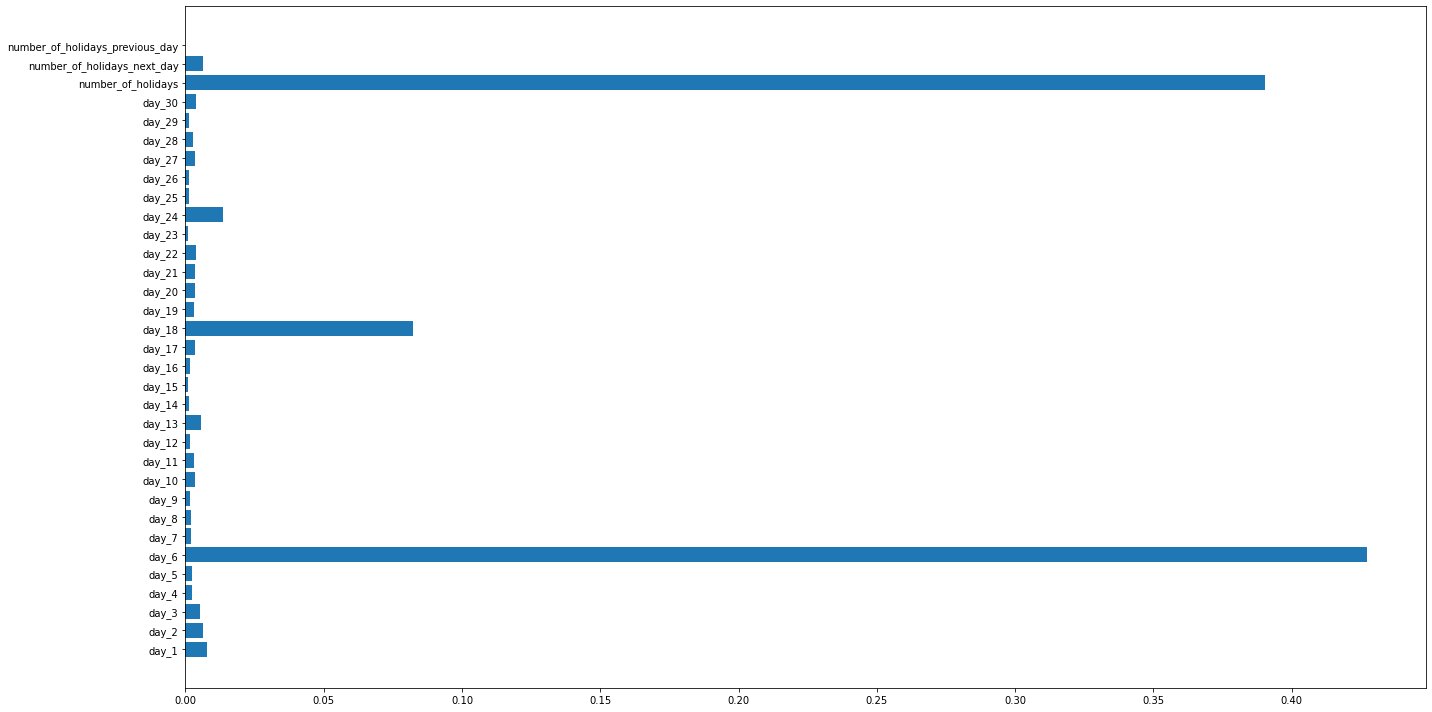

In [21]:
plt.figure(figsize=(20, 10))
plt.barh(covariates, list(xgboost_result[1].feature_importances_))
plt.tight_layout()